# Perform standard imports and load datasets

In [201]:
import pandas as pd
import numpy as np
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from fbprophet import Prophet

In [202]:
## Load dataset which is from 2006 to 2018
df=pd.read_csv("AMZN.csv",index_col='Date', parse_dates=True)

In [203]:
#Resample data with with Frequency = Buisness data
ds=df["Open"].resample("B").mean()

In [205]:
ds.tail(30)

Date
2017-11-20    1129.77
2017-11-21    1132.86
2017-11-22    1141.00
2017-11-23        NaN
2017-11-24    1160.70
2017-11-27    1202.66
2017-11-28    1204.88
2017-11-29    1194.80
2017-11-30    1167.10
2017-12-01    1172.05
2017-12-04    1173.85
2017-12-05    1128.26
2017-12-06    1137.99
2017-12-07    1156.59
2017-12-08    1170.40
2017-12-11    1164.60
2017-12-12    1166.51
2017-12-13    1170.00
2017-12-14    1163.71
2017-12-15    1179.03
2017-12-18    1187.37
2017-12-19    1189.15
2017-12-20    1190.50
2017-12-21    1175.90
2017-12-22    1172.08
2017-12-25        NaN
2017-12-26    1168.36
2017-12-27    1179.91
2017-12-28    1189.00
2017-12-29    1182.35
Freq: B, Name: Open, dtype: float64

In [206]:
#Fill Nan dates with ffill method
ds=ds.fillna(method='ffill')

In [207]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [208]:
#Drop Extra columns
df.drop(['High','Low','Close','Name'],axis=1,inplace=True)

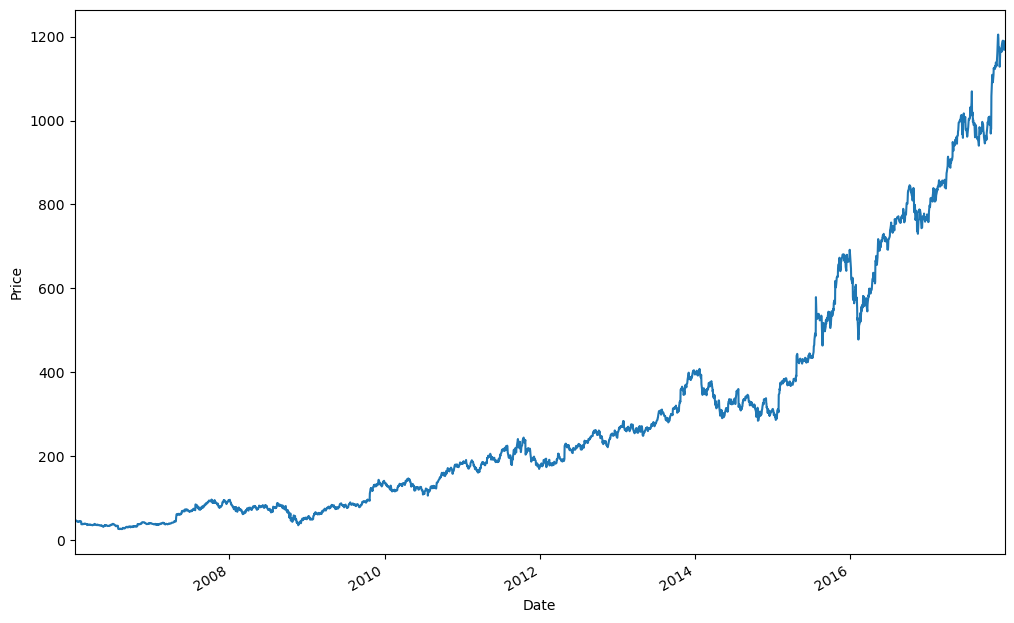

In [209]:
df['Open'].plot(xlabel='Date',ylabel='Price',figsize=(12,8)).autoscale(axis='x',tight=True)


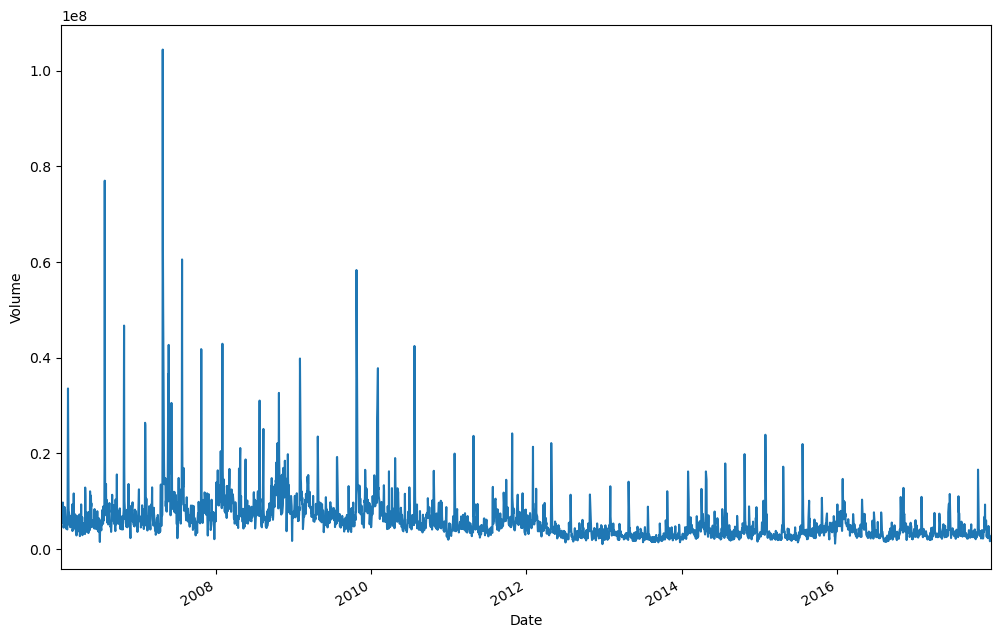

In [210]:
df['Volume'].plot(xlabel='Date',ylabel='Volume',figsize=(12,8)).autoscale(axis='x',tight=True);

# Run an ETS Decomposition

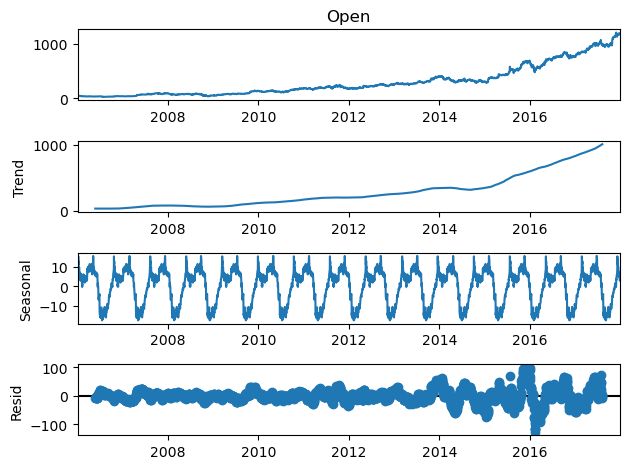

In [212]:
result= seasonal_decompose(df['Open'],model='additive',period=200)
result.plot();

# Augmented Dickey-Fuller Test

In [213]:
#Used to check statinarity of Data 
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [214]:
adf_test(ds)

Augmented Dickey-Fuller Test: 
ADF test statistic         3.133579
p-value                    1.000000
# lags used                4.000000
# observations          3124.000000
critical value (1%)       -3.432445
critical value (5%)       -2.862466
critical value (10%)      -2.567263
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


# Granger Causality Test

In [215]:
#Used to check correlation between both the columns
grangercausalitytests(df[['Open','Volume']],maxlag=12);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0794  , p=0.7781  , df_denom=3015, df_num=1
ssr based chi2 test:   chi2=0.0795  , p=0.7780  , df=1
likelihood ratio test: chi2=0.0795  , p=0.7780  , df=1
parameter F test:         F=0.0794  , p=0.7781  , df_denom=3015, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2436  , p=0.7838  , df_denom=3012, df_num=2
ssr based chi2 test:   chi2=0.4880  , p=0.7835  , df=2
likelihood ratio test: chi2=0.4880  , p=0.7835  , df=2
parameter F test:         F=0.2436  , p=0.7838  , df_denom=3012, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4331  , p=0.7293  , df_denom=3009, df_num=3
ssr based chi2 test:   chi2=1.3022  , p=0.7286  , df=3
likelihood ratio test: chi2=1.3019  , p=0.7287  , df=3
parameter F test:         F=0.4331  , p=0.7293  , df_denom=3009, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3123  , p=0.

This means volume is having no correlation with price of the stock i.e Open. so now we will just use open price to predict stock price.

In [216]:
#Drop volume column
df.drop(['Volume'],axis=1,inplace=True)

In [217]:
pip install pmdarima

In [218]:
from pmdarima import auto_arima

In [219]:
#shape
ds.shape

(3129,)

In [220]:
#Split the data into train/test sets in the ratio of 83/17
train_data =ds[:2600]
test_data = ds[2600:]

In [221]:
#Determine the (p,i,q) ARIMA Orders using pmdarima.auto_arima
stepwise_fit = auto_arima(df['Open'], start_p=0, start_q=0,
                          max_p=9 ,max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

c:\users\karti\anaconda30\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=22365.282, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=21392.236, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=22363.282, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=21089.297, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=20914.404, Time=0.42 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=20781.279, Time=0.57 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=20659.203, Time=0.83 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=20609.915, Time=1.01 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=20539.503, Time=1.25 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=20485.369, Time=1.36 sec
 ARIMA(9,2,0)(0,0,0)[0] intercept   : AIC=20440.737, Time=1.57 sec
 ARIMA(9,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(8,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.93 sec
 ARIMA(9,2,0)(0,0,0)[0]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3019
Model:               SARIMAX(9, 2, 0)   Log Likelihood              -10209.369
Date:                Sun, 23 May 2021   AIC                          20438.737
Time:                        08:36:31   BIC                          20498.858
Sample:                             0   HQIC                         20460.356
                               - 3019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9386      0.007   -129.491      0.000      -0.953      -0.924
ar.L2         -0.8205      0.012    -66.108      0.000      -0.845      -0.796
ar.L3         -0.7532      0.016    -48.211      0.000      -0.784      -0.723
ar.L4         -0.6840      0.017    -39.631      0.000      -0.718      -0.650
ar.L5         -0.5853      0.017    -33.756      0.000      -0.619      -0.551
ar.L6         -0.4555      0.018    -25.597      0.000      -0.490      -0.421
ar.L7         -0.3743      0.018    -21.266      0.000      -0.409      -0.340
ar.L8         -0.2504      0.015    -16.461      0.000      -0.280      -0.221
ar.L9         -0.1240      0.011    -11.206      0.000      -0.146      -0.102
sigma2        50.8790      0.395    128.909      0.000      50.105      51.653
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             68095.39
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              25.46   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
# Fit an ARIMA(p,i,q) Model
model = ARIMA(train_data,order=(9, 2, 0))
results = model.fit()
results.summary()

c:\users\karti\anaconda30\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D2.Open   No. Observations:                 2598
Model:                 ARIMA(9, 2, 0)   Log Likelihood               -7964.842
Method:                       css-mle   S.D. of innovations              5.189
Date:                Sun, 23 May 2021   AIC                          15951.684
Time:                        08:36:34   BIC                          16016.171
Sample:                    01-05-2006   HQIC                         15975.050
                         - 12-21-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.016      0.024      0.981      -0.030       0.031
ar.L1.D2.Open    -1.0066      0.020    -51.577      0.000      -1.045      -0.968
ar.L2.D2.Open    -0.9098      0.027    -33.320      0.000      -0.963      -0.856
ar.L3.D2.Open    -0.8826      0.032    -27.894      0.000      -0.945      -0.821
ar.L4.D2.Open    -0.7662      0.035    -22.075      0.000      -0.834      -0.698
ar.L5.D2.Open    -0.6324      0.036    -17.641      0.000      -0.703      -0.562
ar.L6.D2.Open    -0.5015      0.035    -14.379      0.000      -0.570      -0.433
ar.L7.D2.Open    -0.4104      0.032    -12.883      0.000      -0.473      -0.348
ar.L8.D2.Open    -0.2612      0.028     -9.495      0.000      -0.315      -0.207
ar.L9.D2.Open    -0.1030      0.020     -5.225      0.000      -0.142      -0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8754           -0.8001j            1.1859           -0.1178
AR.2            0.8754           +0.8001j            1.1859            0.1178
AR.3            0.2532           -1.1901j            1.2167           -0.2166
AR.4            0.2532           +1.1901j            1.2167            0.2166
AR.5           -0.5779           -1.2248j            1.3543           -0.3202
AR.6           -0.5779           +1.2248j            1.3543            0.3202
AR.7           -1.3053           -0.0000j            1.3053           -0.5000
AR.8           -1.1656           -0.7671j            1.3954           -0.4074
AR.9           -1.1656           +0.7671j            1.3954            0.4074
-----------------------------------------------------------------------------
"""

In [223]:
#Predict the Result for test data
start=len(train_data)
end=len(ds)-1
predictarima = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(9,2,0)')

<AxesSubplot:xlabel='Date', ylabel='Price'>

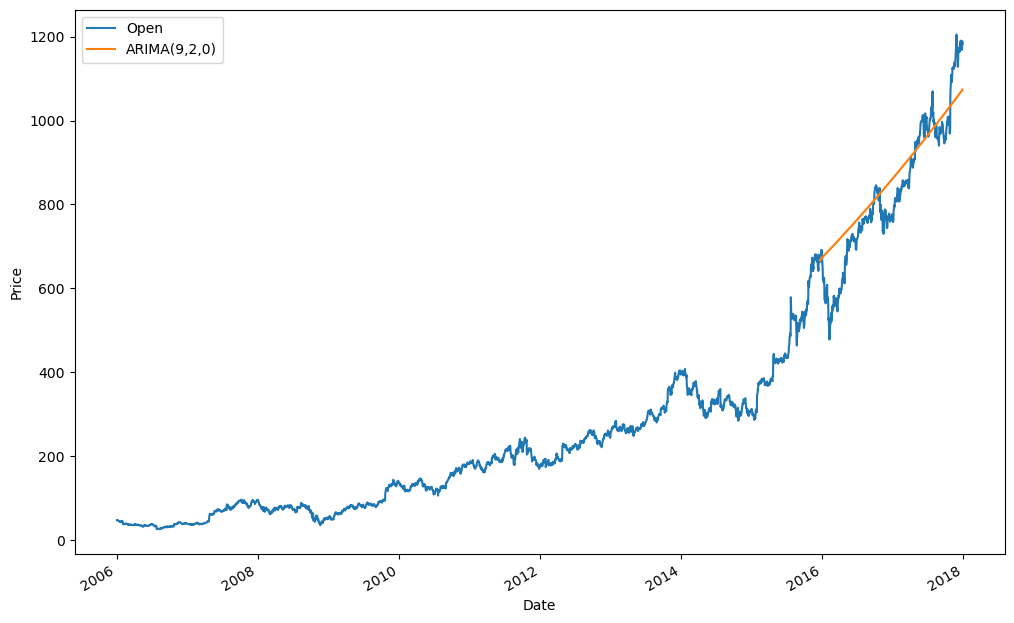

In [224]:
# Plot predictions against known values 
df['Open'].plot(figsize=(12,8),legend=True)
#train_data.plot(figsize=(12,8),legend=True)
predictarima.plot(xlabel='Date',ylabel='Price',legend=True)

In [225]:
# Evaluate the Model
from statsmodels.tools.eval_measures import rmse
error_arima= rmse(test_data, predictarima)
error_arima

71.7053838271658

In [226]:
test_data.mean()

830.6720604914934

With Arima model our RMSE is 71.70 where our mean is 830.67

# Retrain the model on the full data, and forecast the future

In [227]:
start=len(ds)
end=len(ds)+550
model = ARIMA(ds,order=(9,2,0))
results = model.fit()
fcastarima = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(9,2,0)')

c:\users\karti\anaconda30\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


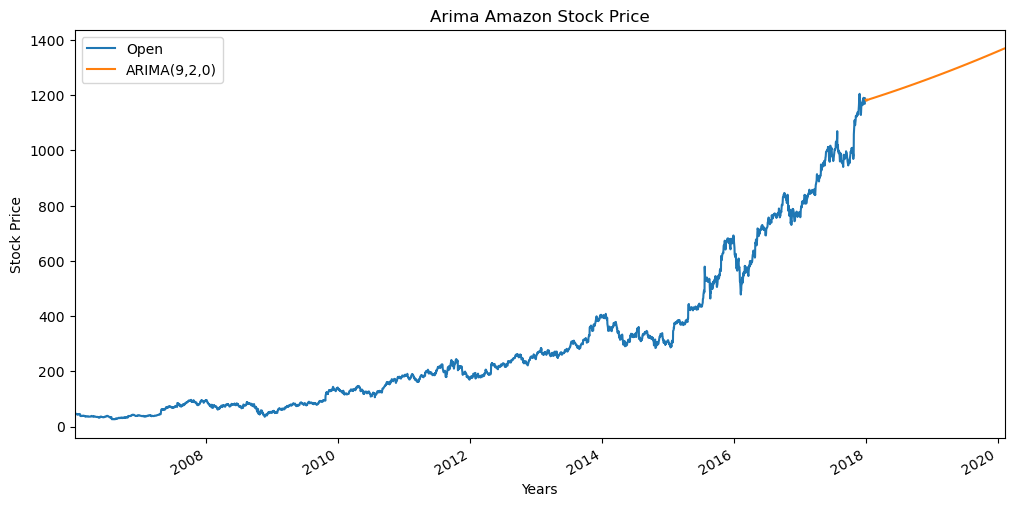

In [228]:
# Plot forecast against known values
title = 'Arima Amazon Stock Price'
ylabel='Stock Price'
xlabel='Years' 

ax = df['Open'].plot(legend=True,figsize=(12,6),title=title)
fcastarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Seasonal Autoregressive Integrated Moving Averages

In [229]:
#Determine the SARIMA(p,d,q)(P,D,Q)m Orders using pmdarima.auto_arima
stepwise_fit = auto_arima(df['Open'], start_p=0, start_q=0,
                          max_p=9 ,max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=22362.734, Time=0.84 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=22363.282, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=21391.011, Time=0.35 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=21390.236, Time=0.10 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=21391.098, Time=0.38 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=21392.022, Time=0.66 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=21087.297, Time=0.17 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=21087.474, Time=0.41 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=21087.605, Time=0.52 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=21088.329, Time=1.08 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=20912.404, Time=0.23 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=20912.561, Time=0.64 sec
 ARIMA(3,2,0)(0,0,1)[12]             : AIC=20912.697, Time=0.60 sec
 ARIMA(3,2,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3019
Model:               SARIMAX(9, 2, 0)   Log Likelihood              -10209.369
Date:                Sun, 23 May 2021   AIC                          20438.737
Time:                        08:37:43   BIC                          20498.858
Sample:                             0   HQIC                         20460.356
                               - 3019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9386      0.007   -129.491      0.000      -0.953      -0.924
ar.L2         -0.8205      0.012    -66.108      0.000      -0.845      -0.796
ar.L3         -0.7532      0.016    -48.211      0.000      -0.784      -0.723
ar.L4         -0.6840      0.017    -39.631      0.000      -0.718      -0.650
ar.L5         -0.5853      0.017    -33.756      0.000      -0.619      -0.551
ar.L6         -0.4555      0.018    -25.597      0.000      -0.490      -0.421
ar.L7         -0.3743      0.018    -21.266      0.000      -0.409      -0.340
ar.L8         -0.2504      0.015    -16.461      0.000      -0.280      -0.221
ar.L9         -0.1240      0.011    -11.206      0.000      -0.146      -0.102
sigma2        50.8790      0.395    128.909      0.000      50.105      51.653
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             68095.39
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              25.46   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [230]:
# Fit a SARIMA(9,2,0)(0,0,0,12) Model
model = SARIMAX(train_data,order=(9, 2, 0),seasonal_order=(0,0,0,12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 2600
Model:               SARIMAX(9, 2, 0)   Log Likelihood               -7964.842
Date:                Sun, 23 May 2021   AIC                          15949.684
Time:                        08:37:44   BIC                          16008.309
Sample:                    01-03-2006   HQIC                         15970.927
                         - 12-21-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0065      0.006   -158.863      0.000      -1.019      -0.994
ar.L2         -0.9098      0.016    -58.386      0.000      -0.940      -0.879
ar.L3         -0.8826      0.019    -45.631      0.000      -0.921      -0.845
ar.L4         -0.7662      0.025    -31.077      0.000      -0.815      -0.718
ar.L5         -0.6324      0.025    -25.672      0.000      -0.681      -0.584
ar.L6         -0.5015      0.023    -21.384      0.000      -0.547      -0.456
ar.L7         -0.4104      0.022    -18.978      0.000      -0.453      -0.368
ar.L8         -0.2612      0.019    -13.772      0.000      -0.298      -0.224
ar.L9         -0.1030      0.014     -7.498      0.000      -0.130      -0.076
sigma2        26.9216      0.187    144.244      0.000      26.556      27.287
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):            199461.56
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):              13.50   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [231]:
#Train the Result for test data
start=len(train_data)
end=len(ds)-1
prediction = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(9,2,0)(0,0,0,12)')

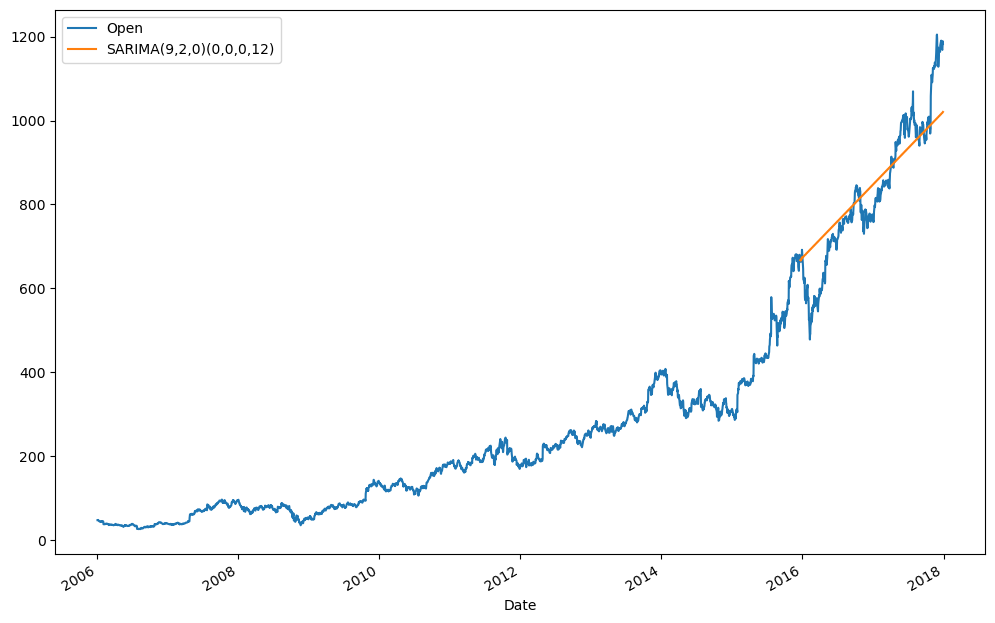

In [232]:
# Plot predictions against known values 
df['Open'].plot(figsize=(12,8),legend=True)
#train_data.plot(figsize=(12,8),legend=True)
prediction.plot(legend=True);

In [233]:
from statsmodels.tools.eval_measures import rmse
error_sarimax= rmse(test_data, prediction)
error_sarimax

77.2732220592212

In [234]:
# Retrain the model on the full data, and forecast the future
start=len(ds)
end=len(ds)+550
model = SARIMAX(ds,order=(9,2,0),seasonal_order=(0,0,0,12))
result = model.fit()
fcastsarimax = result.predict(start=start, end=end, typ='levels').rename('SARIMA(9,2,0)(0,0,0,12 Forecast')

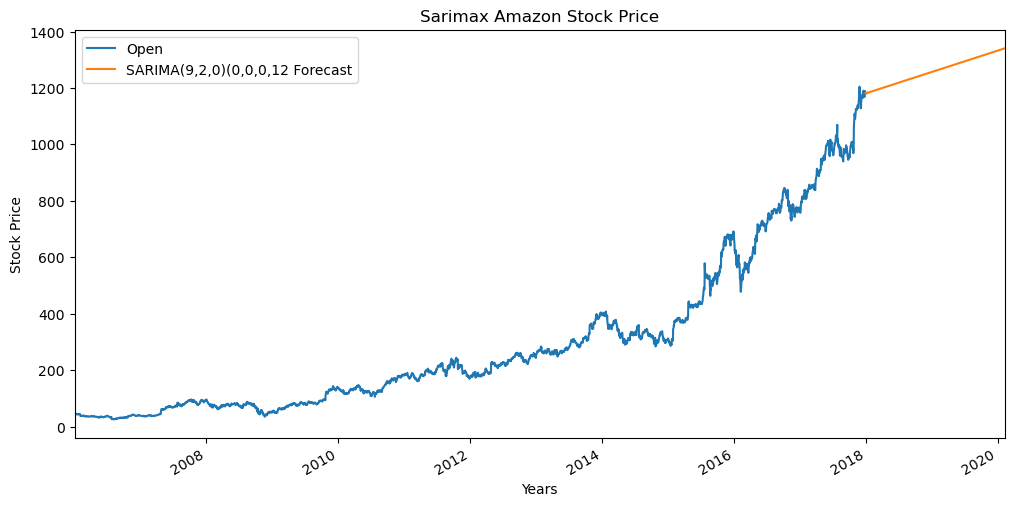

In [235]:
# Plot forecast against known values
title = 'Sarimax Amazon Stock Price'
ylabel='Stock Price'
xlabel='Years' 

ax = df['Open'].plot(legend=True,figsize=(12,6),title=title)
fcastsarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# FbProphet

In [113]:
#Load Data
dp=pd.read_csv("AMZN.csv")

In [114]:
#Drop extra columns
dp.drop(['High','Low','Close','Name','Volume'],axis=1,inplace=True)

In [115]:
dp.head()

,Date,Open
0,2006-01-03,47.47
1,2006-01-04,47.48
2,2006-01-05,47.16
3,2006-01-06,47.97
4,2006-01-09,46.55


In [116]:
# Format the Data
dp.columns = ['ds','y']

In [117]:
dp['ds'] = pd.to_datetime(dp['ds'])

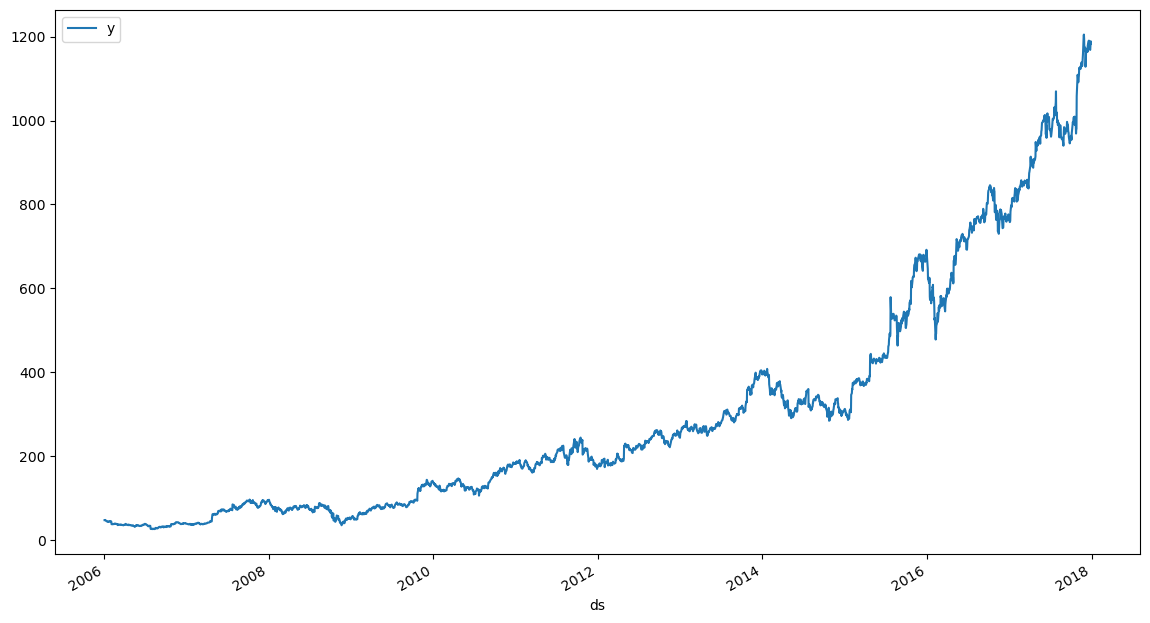

In [118]:
#Plot graph
dp.plot(x='ds',y='y',figsize=(14,8));

In [119]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3019 non-null   datetime64[ns]
 1   y       3019 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.3 KB


In [120]:
#Split the data into train/test sets
train = dp.iloc[:2716]
test = dp.iloc[2716:]

In [66]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [67]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [68]:
#Load Holiday Data
dates=pd.read_excel('2006_2020_us_holiday_list.xlsx')

In [69]:
#Change the holiday_dates into datetime format
dates['holiday_dates']=pd.to_datetime(dates['holiday_dates'])

In [70]:
dates['holiday_dates']

0     2006-01-01
1     2006-01-02
2     2006-01-16
3     2006-02-20
4     2006-05-29
         ...    
150   2020-09-07
151   2020-10-12
152   2020-11-11
153   2020-11-26
154   2020-12-25
Name: holiday_dates, Length: 155, dtype: datetime64[ns]

In [191]:
# Retrain the model on the full data, and forecast the future
m = Prophet(interval_width=0.80,seasonality_mode='additive',holidays=holiday_special_events)
m.fit(train)
future = m.make_future_dataframe(periods=313,freq='B')
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [192]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3024,2017-12-22,1064.667602,969.385750,1175.263477,959.272491,1161.689400,8.359970,8.359970,8.359970,0.0,...,1.109180,1.109180,1.109180,7.250791,7.250791,7.250791,0.0,0.0,0.0,1073.027573
3025,2017-12-25,1066.622864,967.582411,1179.318397,959.169280,1165.142866,7.256809,7.256809,7.256809,0.0,...,1.045832,1.045832,1.045832,6.210977,6.210977,6.210977,0.0,0.0,0.0,1073.879674
3026,2017-12-26,1067.274618,963.983994,1171.316301,959.338975,1166.294022,6.520727,6.520727,6.520727,0.0,...,0.673076,0.673076,0.673076,5.847650,5.847650,5.847650,0.0,0.0,0.0,1073.795345
3027,2017-12-27,1067.926372,960.837468,1178.559715,959.571674,1167.445177,6.231396,6.231396,6.231396,0.0,...,0.754432,0.754432,0.754432,5.476963,5.476963,5.476963,0.0,0.0,0.0,1074.157768
3028,2017-12-28,1068.578126,968.743557,1175.168319,959.833156,1168.460563,6.123838,6.123838,6.123838,0.0,...,1.024542,1.024542,1.024542,5.099295,5.099295,5.099295,0.0,0.0,0.0,1074.701964


<AxesSubplot:xlabel='ds'>

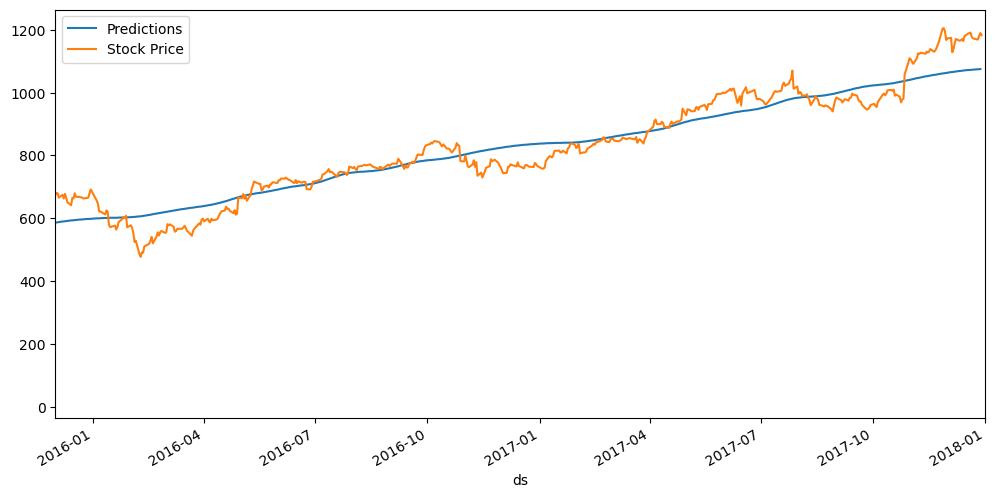

In [193]:
# Plot forecast against known values
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,6))
dp.plot(x='ds',y='y',label='Stock Price',legend=True,ax=ax,xlim=('2015-12-01','2018-01-01'))

In [194]:
predictions = forecast.iloc[-303:]['yhat']

In [195]:
#Calculate the RMSE
from statsmodels.tools.eval_measures import rmse
rmse(predictions,test['y'])

53.42248729425881

In [190]:
#Mean of test Data
test['y'].mean()

935.1688778877889

In [196]:
# Retrain the model on the full data, and forecast the future
m = Prophet(interval_width=0.80,seasonality_mode='additive',holidays=holiday_special_events)
m.fit(dp)
future = m.make_future_dataframe(periods=603,freq='B')
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

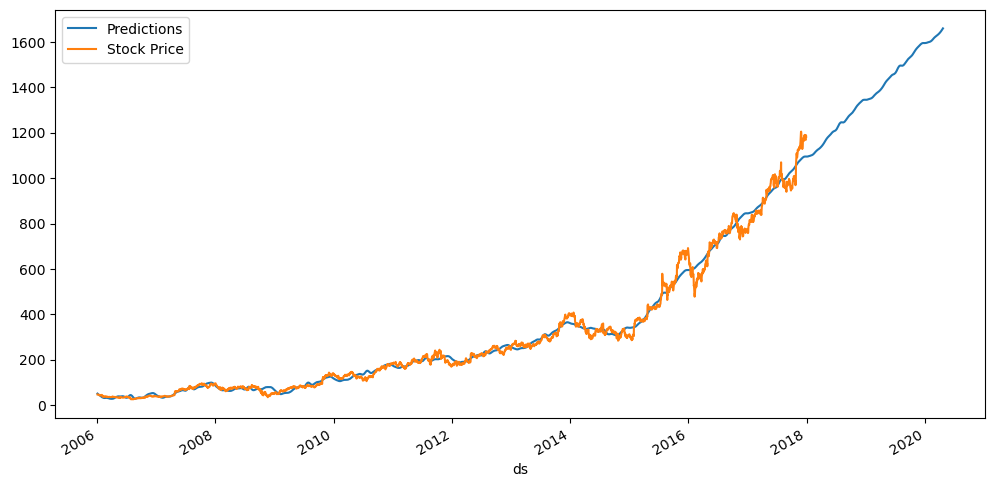

In [197]:
# Plot forecast against known values
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,6))
dp.plot(x='ds',y='y',label='Stock Price',legend=True,ax=ax)

We exploited 3 varied models for the stock price prediction i.e. ARIMA, SARIMA & FBprophet and received an RMSE of 71.70, 77.27 & 53.42 respectively for the mean of x. We noticed ARIMA works better than SARIMA plausible reason for this could be that there's no seasonality in the stock market trends for the Amazon Stocks. FBprophet performs the best because it exploits features like public holidays for the fluctuation of price, another reason is that it is a non-linear model and hence fits the expected distribution better.